## Training a model

This notebook describes how to train and evaluate a model using 1-dimensional Melspectograms, i.e., the same process that we would obtain running the command: 

```make eval use='MEL' dim=1 batch=1```

This notebook is presented here only for illustration pourposes. So we will get rid off the nuances that make the project run smoothly using ```make``` and we will store all the data in the temp directory.

Inspite we don't have a class system, inheritance, scopes and any other software sugar here, the process we are about to describe follows the same steps than those implemented to support ```make``` commands.



### Creating a TRAIN/TEST dataset split 

First, we initialize some reference values and import generic modules.

In [162]:
import os
import librosa as lbr
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA = '../data/interim'
TEMP = '../data/temp'
TRAIN_DIR = os.path.join(TEMP, 'train')
TEST_DIR = os.path.join(TEMP, 'test')

random.seed(42)

mel = lambda x: lbr.feature.melspectrogram(x, sr=22050)

categories = [
    {'name': 'blues', 'klass':0}, {'name': 'classical', 'klass':1}, {'name': 'country', 'klass':2},
    {'name': 'disco', 'klass':3}, {'name': 'hiphop', 'klass':4}, {'name': 'jazz', 'klass':5}, 
    {'name': 'metal', 'klass':6}, {'name': 'pop', 'klass':7}, {'name': 'reggae', 'klass':8},
    {'name': 'rock', 'klass':9} 
]

Now we generate a TRAIN and TEST datasets.

Since the original dataset is completely balanced, we will create a stratified split between TRAIN and TEST datasets. Our strategy consists of walking through each category picking only a 30% of the songs for TEST and the remaining 70% for TRAIN.

In [163]:
train_songs = []
test_songs = []

for cat in categories:
    songs = os.listdir(os.path.join(DATA, cat['name']))
    songs = random.sample(songs, len(songs))
    split = int(len(songs)*.7)
    
    for song in songs[:split]:
        train_songs.append({
            'name': str(cat['klass']) + '_' + song,
            'klass': cat['klass'],
            'src': os.path.join(DATA, cat['name'], song)
        })
    for song in songs[split:len(songs)]:
        test_songs.append({
            'name': str(cat['klass']) + '_' + song,
            'klass': cat['klass'],
            'src': os.path.join(DATA, cat['name'], song)
        })

Before processing, we clean (or create) folders to store our TRAIN and TEST datasets.

In [164]:
if os.path.isdir(TRAIN_DIR):
    shutil.rmtree(TRAIN_DIR)
if os.path.isdir(TEST_DIR):
    shutil.rmtree(TEST_DIR)
os.makedirs(TRAIN_DIR)
os.makedirs(TEST_DIR)

To augment our initial dataset, we are going to cut each training song in several pieces. Each excerpt will cover 3s of its original track (30*0.1 and we will overlap each excerpt by 50%.

As a result, we are going to train our "weak learners" on the excerpts, not on full songs.

In [165]:
X = []
Y = []

for song in tqdm(train_songs):
    signal, sr = lbr.load(song['src'])
    signal = signal[:660000]
    
    chunks = []
    chunk = int(signal.shape[0]*0.1);
    offset = int(chunk*(1.-0.5))
    
    for i in range(0, signal.shape[0] - chunk + offset, offset):
        chunks.append(signal[i:i + chunk])

    chunks = np.array(chunks)
    
    excerpts = []
    
    for excerpt in chunks:
        excerpts.append(mel(excerpt))
    
    X.extend(excerpts)
    Y.extend([np.eye(10, k=song['klass'], dtype=int)[0]] * len(excerpts))
    
np.save(os.path.join(TRAIN_DIR, 'x.npy'), np.array(X))
np.save(os.path.join(TRAIN_DIR, 'y.npy'), np.array(Y))

100%|██████████| 700/700 [02:19<00:00,  5.00it/s]


Even though we have processed the training songs to augment the number of samples during the fitting process for our models, the test songs will remain untoched. 

The reason for this is that we want to obtain predictions for full songs (a.k.a. 30s tracks) not for the excerpts they contain.

In [166]:
for song in test_songs:
    shutil.copyfile(song['src'], os.path.join(TEST_DIR, song['name']))

### Training the model on the augmented TRAIN dataset

In [167]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

First we create a VALIDATION dataset to guide the fitting process. We use a 20% of the training songs for this matter.

In addition, we define an early stop strategy that will halt the process in case it detects that no progress has been achieved after 15 epochs.

In [168]:
X = np.load(os.path.join(TRAIN_DIR,  'x.npy'))
Y = np.load(os.path.join(TRAIN_DIR,  'y.npy'))

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

halt = EarlyStopping(
    monitor='val_loss', # What metric are we watching out
    min_delta=0.001,    # What do we consider an "improvement"
    patience=15,        # How many epochs do we want to wait
    verbose=0,
    mode='auto',
    restore_best_weights=True # If halts, recover the best recorded model.
)

DROPOUT=0.3

Now, finally, we define and fit our "weak learner"

In [169]:
model = Sequential()

model.add(Conv1D(
        filters=16,
        kernel_size=3,
        strides=1,
        input_shape=(X_train[0].shape[0],X_train[0].shape[1]),
        activation='relu'
    )
)

model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(DROPOUT))

model.add(Conv1D(
        filters=32,
        kernel_size=3,
        strides=1,
        activation='relu'
    )
)

model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(DROPOUT))

model.add(Conv1D(
        filters=64,
        kernel_size=3,
        strides=1,
        activation='relu'
    )
)

model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(DROPOUT))

model.add(LSTM(100, dropout=DROPOUT, kernel_regularizer=l2(0.001)))
model.add(Dense(10, activation="softmax"))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    metrics=['accuracy']
)

In [171]:
history = model.fit(
    X_train, Y_train,
    batch_size=15,  # Deliberately low, to avoid alloc exceptions
    epochs=100,  # 100 epochs will (probably) overfit. We trust in halt
    validation_data=(X_val, Y_val),
    callbacks=[halt],
    verbose=1
)

Train on 10640 samples, validate on 2660 samples
Epoch 1/100
10640/10640 [==============================] - 17s 2ms/step - loss: 1.4612 - acc: 0.4843 - val_loss: 1.3589 - val_acc: 0.5316
Epoch 2/100
10640/10640 [==============================] - 22s 2ms/step - loss: 1.4058 - acc: 0.5024 - val_loss: 1.3798 - val_acc: 0.5177
Epoch 3/100
10640/10640 [==============================] - 16s 2ms/step - loss: 1.3734 - acc: 0.5156 - val_loss: 1.3612 - val_acc: 0.5248
Epoch 4/100
10640/10640 [==============================] - 16s 2ms/step - loss: 1.3502 - acc: 0.5294 - val_loss: 1.2902 - val_acc: 0.5556
Epoch 5/100
10640/10640 [==============================] - 19s 2ms/step - loss: 1.3140 - acc: 0.5445 - val_loss: 1.2916 - val_acc: 0.5492
Epoch 6/100
10640/10640 [==============================] - 17s 2ms/step - loss: 1.2940 - acc: 0.5480 - val_loss: 1.2577 - val_acc: 0.5680
Epoch 7/100
10640/10640 [==============================] - 17s 2ms/step - loss: 1.2700 - acc: 0.5643 - val_loss: 1.2758 - v

10640/10640 [==============================] - 23s 2ms/step - loss: 0.9089 - acc: 0.6941 - val_loss: 0.9858 - val_acc: 0.6756
Epoch 60/100
10640/10640 [==============================] - 23s 2ms/step - loss: 0.8926 - acc: 0.7039 - val_loss: 0.9309 - val_acc: 0.6936
Epoch 61/100
10640/10640 [==============================] - 24s 2ms/step - loss: 0.8945 - acc: 0.7059 - val_loss: 0.9376 - val_acc: 0.6929
Epoch 62/100
10640/10640 [==============================] - 24s 2ms/step - loss: 0.8932 - acc: 0.7106 - val_loss: 0.9640 - val_acc: 0.6850
Epoch 63/100
10640/10640 [==============================] - 24s 2ms/step - loss: 0.8739 - acc: 0.7136 - val_loss: 0.9032 - val_acc: 0.6989
Epoch 64/100
10640/10640 [==============================] - 24s 2ms/step - loss: 0.8890 - acc: 0.7061 - val_loss: 1.0162 - val_acc: 0.6515
Epoch 65/100
10640/10640 [==============================] - 23s 2ms/step - loss: 0.9005 - acc: 0.6997 - val_loss: 0.9693 - val_acc: 0.6729
Epoch 66/100
10640/10640 [==============

After fitting the algorithm, we can plot the evolution of accuracy on both VALIDATION and TRAIN datasets:

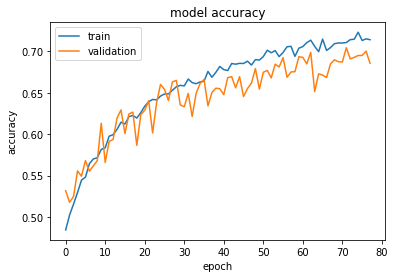

In [172]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

And the same for the losses functions

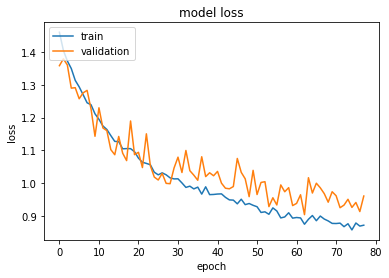

In [173]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

A carefull look on the previous charts reveal that the progress in **validation_loss** shows a pattern: it can achieve a big improvement followed by a (long) plateau. 

That behaviour could be due to the presence of LSTM layers which have stochastic behaviour. And that's the reason why we choos a high **patience** value in our halt method: we want to stop when we are truly confident that the progress has been stopped.

### Evaluating a model on a non-augmented TEST dataset

So far, we have a model able to produce predictions for 3s-length chunks of songs in GTZAN. 

But we need predictions for 30s-length songs, which are the original tracks contained in the GTZAN dataset. Therefore we adopt a "voting" system, considering that our "generalized" model's output it's the most common prediction we can obtain from its exceprts.

I.e., to predict the class of a certain song, we'll first process it in the same fashion we did with each training song, then we'll produce several predictions on each excerpt an adopt the most common value as our final prediction.

In [174]:
songs = [os.path.join(TEST_DIR, x) for x in os.listdir(TEST_DIR)]

klasses = []
predictions = []

for song in tqdm(songs):
    klasses.append(int(os.path.basename(song).split('_')[0]))
    
    # We process each song, exactly the way we did with train_songs.
    signal, sr = lbr.load(song)
    signal = signal[:660000]
    
    chunks = []
    chunk = int(signal.shape[0]*0.1);
    offset = int(chunk*(1.-0.5))
    
    for i in range(0, signal.shape[0] - chunk + offset, offset):
        chunks.append(signal[i:i + chunk])

    chunks = np.array(chunks)
    
    excerpts = []
    
    for excerpt in chunks:
        excerpts.append(mel(excerpt))
    
    excerpts = np.array(excerpts)
    
    
    # Now we have converted a song into a bunch of excerpts.
    # We use our model on each excerpt and take the most common prediction as 
    # our "generalized" model output.
    
    classes = list(model.predict_classes(np.array(excerpts)))
    predictions.append(max(set(classes), key=classes.count))
        

100%|██████████| 300/300 [00:59<00:00,  5.00it/s]


Finally, we evaluate our "generalize" model in terms of accuracy and its confusion matrix:

In [175]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(klasses, predictions)

print("\nConfusion matrix:\n")
print(cm)
display("Overall accuracy: {0:.2f}".format(accuracy_score(klasses, predictions)))


Confusion matrix:

[[20  1  3  4  1  0  0  0  1  0]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 1  1 20  1  0  2  0  1  0  4]
 [ 1  0  0 12  5  1  1  4  2  4]
 [ 1  0  0  0 22  0  1  2  4  0]
 [ 3  2  2  2  0 21  0  0  0  0]
 [ 0  0  0  1  0  1 27  1  0  0]
 [ 0  0  0  2  5  2  0 17  1  3]
 [ 1  0  1  0  6  1  0  1 19  1]
 [ 4  0  4  3  0  0  3  2  1 13]]


'Overall accuracy: 0.67'